# Time Series Forecasting
## Using Machine Learning to IOT Time Series Forecasting / Regression

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [25]:
df = pd.read_csv('train_ML_IOT.csv')
df = df[df['Junction'] == 3] 
df = df.drop(['Junction', 'ID'], axis=1)
df = df.set_index('DateTime')
df.index = pd.to_datetime(df.index)

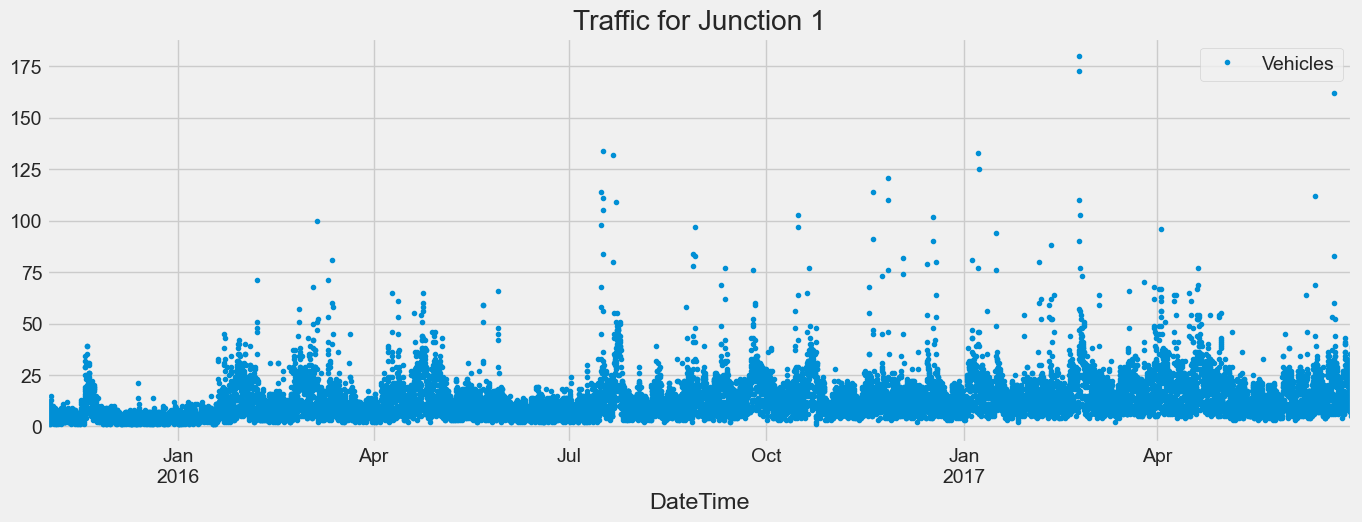

In [26]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Traffic for Junction 1')
plt.show()

# 1. Outlier Analysis and removal

<Axes: ylabel='Frequency'>

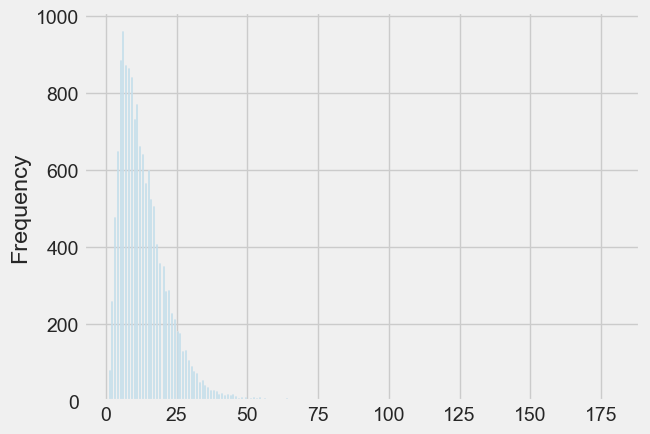

In [27]:
df['Vehicles'].plot(kind='hist', bins=500)

<Axes: title={'center': 'Outliers'}, xlabel='DateTime'>

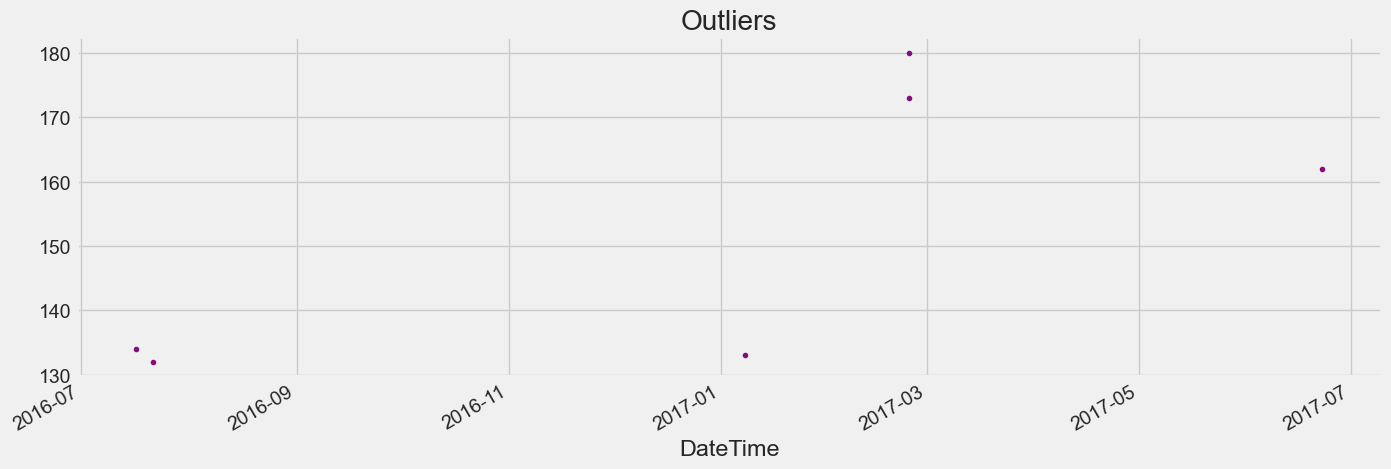

In [28]:
df.query('Vehicles > 130')['Vehicles'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

In [29]:
df = df.query('Vehicles < 130').copy()
df

,Vehicles
DateTime,
2015-11-01 00:00:00,9
2015-11-01 01:00:00,7
2015-11-01 02:00:00,5
2015-11-01 03:00:00,1
2015-11-01 04:00:00,2
...,...
2017-06-30 19:00:00,33
2017-06-30 20:00:00,31
2017-06-30 21:00:00,28


# Reviewing: Train / Test Split

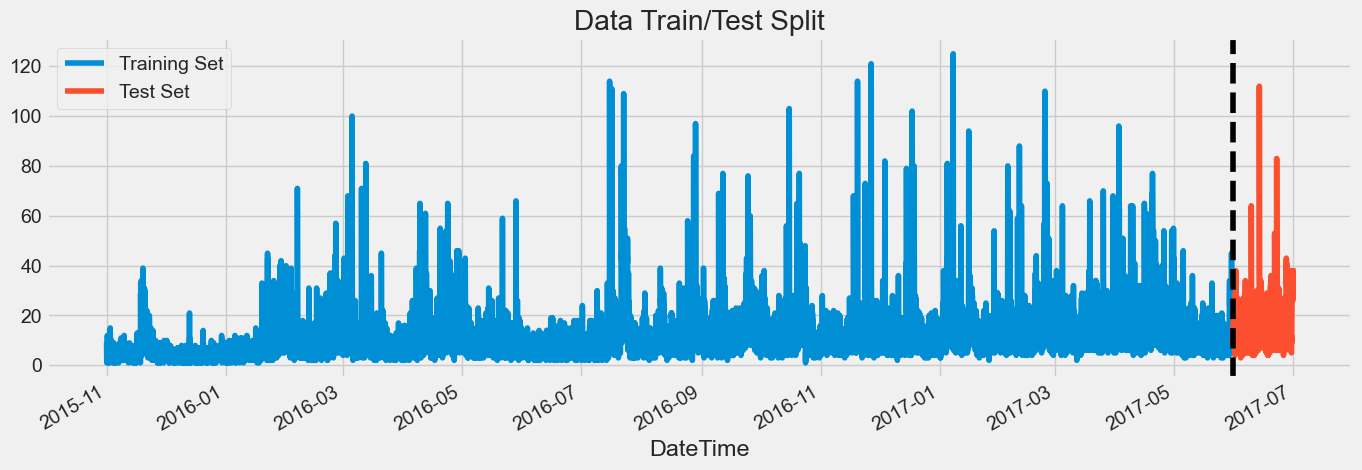

In [30]:
train = df.loc[df.index < '2017-5-31']
test = df.loc[df.index >= '2017-5-31']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2017-5-31', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

1. Time Series Cross Validation

Bir veri setini sadece eğitim ve test verisi olarak ikiye bölmek, bazı verilerin modelin eğitiminde kullanılmamasına neden olabilir. Bu durumda, model belirli verilere aşırı uyum sağlayabilir (overfitting). CV, veriyi birden fazla alt küme (katman) halinde böler ve her bir alt küme sırayla test verisi olarak kullanılır. Bu sayede, her veri öğesi modelin eğitim ve testinde en az bir kez yer alır.

In [31]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*30*1, gap=24)
df = df.sort_index()

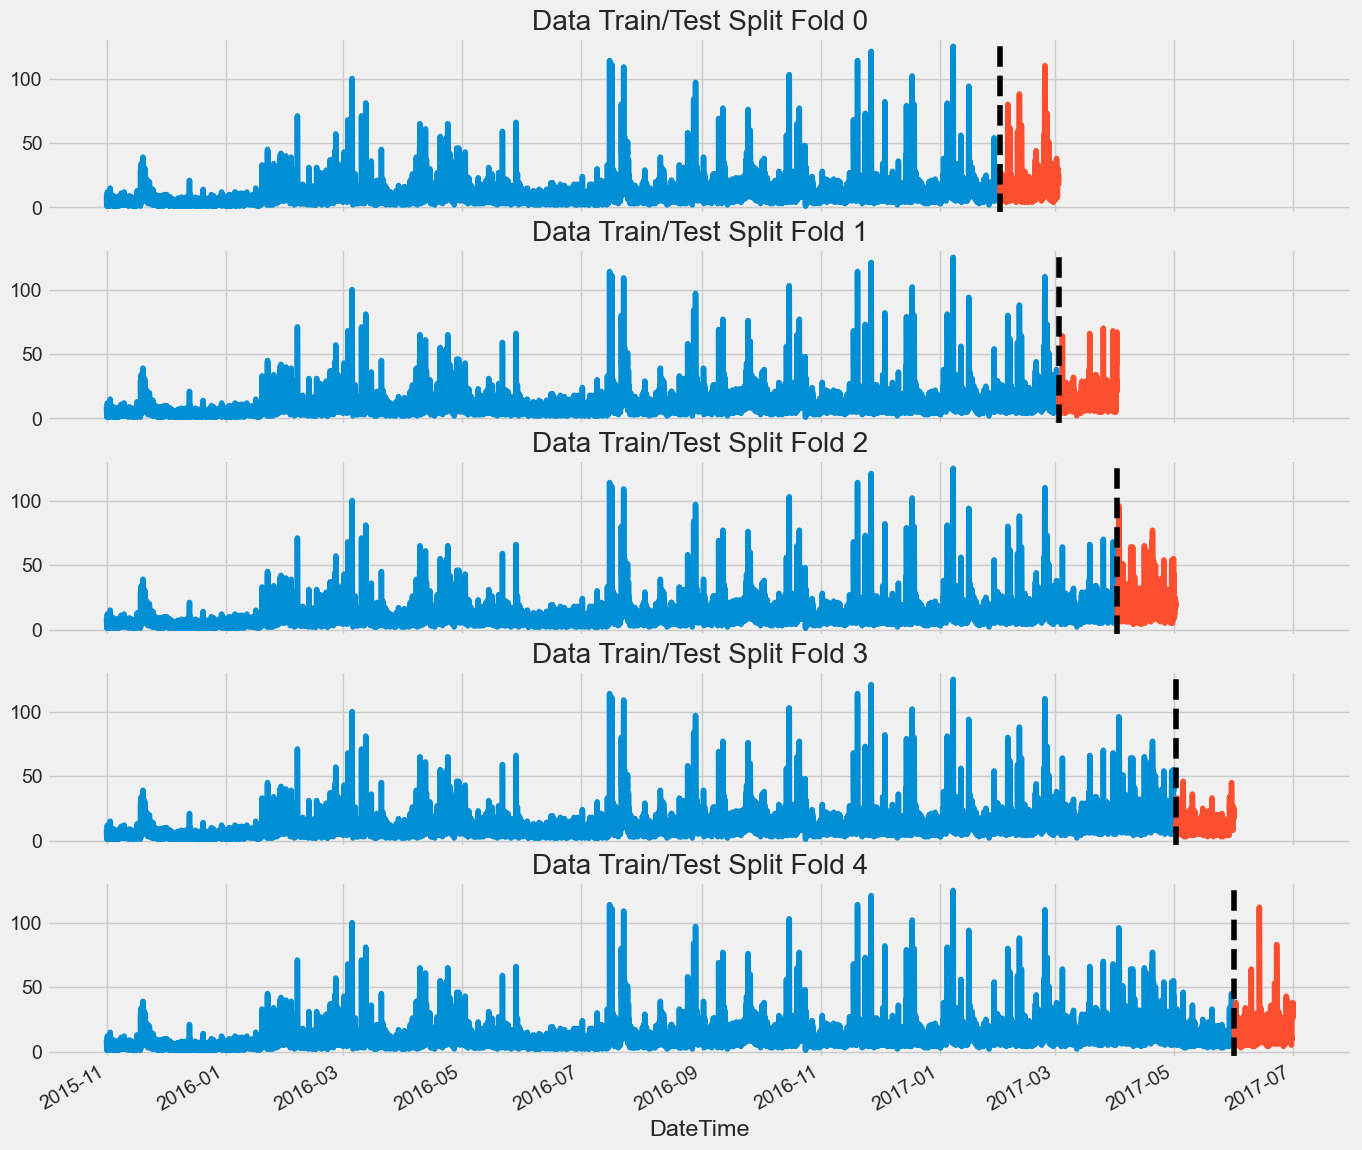

,Vehicles
DateTime,
2017-05-31 23:00:00,15
2017-06-01 00:00:00,17
2017-06-01 01:00:00,9
2017-06-01 02:00:00,7
2017-06-01 03:00:00,6
...,...
2017-06-30 19:00:00,33
2017-06-30 20:00:00,31
2017-06-30 21:00:00,28


In [32]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Vehicles'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Vehicles'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()
test

# 2. Forecasting Horizon Explained
**The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).**

In [33]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)
df

,Vehicles,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
DateTime,,,,,,,,,
2015-11-01 00:00:00,9,0,6,4,11,2015,305,1,44
2015-11-01 01:00:00,7,1,6,4,11,2015,305,1,44
2015-11-01 02:00:00,5,2,6,4,11,2015,305,1,44
2015-11-01 03:00:00,1,3,6,4,11,2015,305,1,44
2015-11-01 04:00:00,2,4,6,4,11,2015,305,1,44
...,...,...,...,...,...,...,...,...,...
2017-06-30 19:00:00,33,19,4,2,6,2017,181,30,26
2017-06-30 20:00:00,31,20,4,2,6,2017,181,30,26
2017-06-30 21:00:00,28,21,4,2,6,2017,181,30,26


In [34]:
# Visualize our Feature / Target Relationship

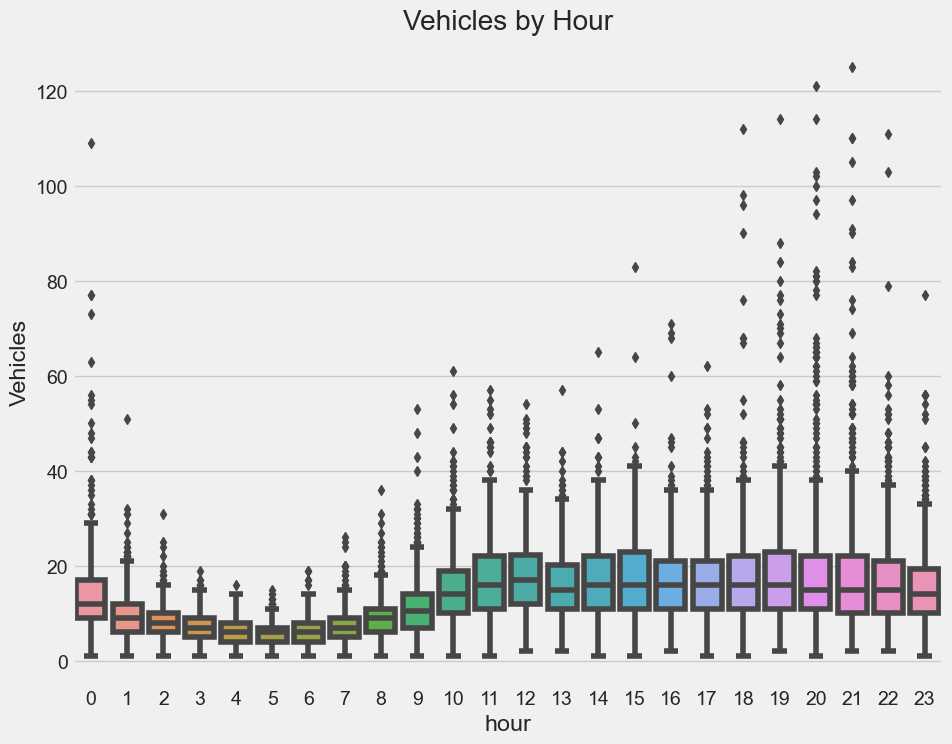

In [35]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='Vehicles')
ax.set_title('Vehicles by Hour')
plt.show()

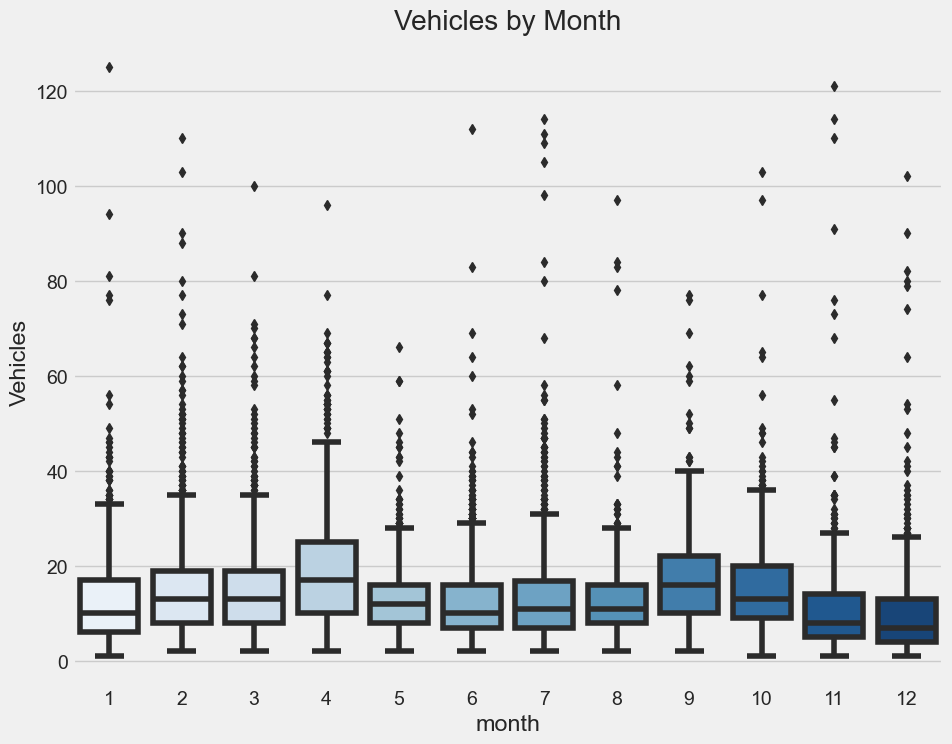

In [36]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Vehicles', palette='Blues')
ax.set_title('Vehicles by Month')
plt.show()

# 3. Lag Features
- What was the target (x) days in the past.
- Bir zaman serisi verisindeki lag, mevcut zaman noktasından önce gelen bir zaman noktasını ifade eder. Lag features ise, mevcut zamandaki değerleri önceki zaman noktalarındaki değerlerle ilişkilendiren özniteliklerdir. Bu öznitelikler, geçmiş değerlerin mevcut değeri tahmin etmede nasıl bir rol oynayabileceğini yakalamak için kullanılır.  Yani, verinin önceki zaman dilimlerine bakarak mevcut değeri tahmin etmek amacıyla kullanılan bir tür özniteliktir. Diyelim ki 2023-08-03 tarihindeki sıcaklığı tahmin etmek istiyoruz. Lag features kullanarak bu tahmini yapabiliriz. Eğer "lag 1" kullanıyorsak, 2023-08-02 tarihindeki sıcaklığı bir önceki günün sıcaklığı olarak tahmin edebiliriz. Benzer şekilde, "lag 2" kullanıyorsak, 2023-08-01 tarihindeki sıcaklığı iki gün önceki sıcaklık olarak tahmin edebiliriz.

In [37]:
def add_lags(df):
    target_map = df['Vehicles'].to_dict()  # target = Vehicles
    df['lag1'] = (df.index - pd.Timedelta('24 hours')).map(target_map)
    print(df['lag1'])
    df['lag2'] = (df.index - pd.Timedelta('48 hours')).map(target_map)
    print(df['lag2'])
    df['lag3'] = (df.index - pd.Timedelta('72 hours')).map(target_map)
    print(df['lag3'])
    return df

In [38]:
target_map = df['Vehicles'].to_dict()  # target = Vehicles

In [39]:
df = add_lags(df)
df

DateTime
2015-11-01 00:00:00     NaN
2015-11-01 01:00:00     NaN
2015-11-01 02:00:00     NaN
2015-11-01 03:00:00     NaN
2015-11-01 04:00:00     NaN
                       ... 
2017-06-30 19:00:00    24.0
2017-06-30 20:00:00    25.0
2017-06-30 21:00:00    22.0
2017-06-30 22:00:00    25.0
2017-06-30 23:00:00    25.0
Name: lag1, Length: 14586, dtype: float64
DateTime
2015-11-01 00:00:00     NaN
2015-11-01 01:00:00     NaN
2015-11-01 02:00:00     NaN
2015-11-01 03:00:00     NaN
2015-11-01 04:00:00     NaN
                       ... 
2017-06-30 19:00:00    31.0
2017-06-30 20:00:00    26.0
2017-06-30 21:00:00    23.0
2017-06-30 22:00:00    19.0
2017-06-30 23:00:00    23.0
Name: lag2, Length: 14586, dtype: float64
DateTime
2015-11-01 00:00:00     NaN
2015-11-01 01:00:00     NaN
2015-11-01 02:00:00     NaN
2015-11-01 03:00:00     NaN
2015-11-01 04:00:00     NaN
                       ... 
2017-06-30 19:00:00    30.0
2017-06-30 20:00:00    25.0
2017-06-30 21:00:00    28.0
2017-06-30 22:00:00  

,Vehicles,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
DateTime,,,,,,,,,,,,
2015-11-01 00:00:00,9,0,6,4,11,2015,305,1,44,NaN,NaN,NaN
2015-11-01 01:00:00,7,1,6,4,11,2015,305,1,44,NaN,NaN,NaN
2015-11-01 02:00:00,5,2,6,4,11,2015,305,1,44,NaN,NaN,NaN
2015-11-01 03:00:00,1,3,6,4,11,2015,305,1,44,NaN,NaN,NaN
2015-11-01 04:00:00,2,4,6,4,11,2015,305,1,44,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-30 19:00:00,33,19,4,2,6,2017,181,30,26,24.0,31.0,30.0
2017-06-30 20:00:00,31,20,4,2,6,2017,181,30,26,25.0,26.0,25.0
2017-06-30 21:00:00,28,21,4,2,6,2017,181,30,26,22.0,23.0,28.0


## Train Using Cross Validation

In [40]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*30*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
scores_r2 = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'Vehicles'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    score_r2 = r2_score(y_test, y_pred)
    scores_r2.append(score_r2)
    scores.append(score)

[16:06:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15.04323	validation_1-rmse:21.64988
[100]	validation_0-rmse:8.55963	validation_1-rmse:13.18783
[200]	validation_0-rmse:7.07560	validation_1-rmse:10.96386
[300]	validation_0-rmse:6.73333	validation_1-rmse:10.38799
[400]	validation_0-rmse:6.56873	validation_1-rmse:10.19494
[500]	validation_0-rmse:6.48140	validation_1-rmse:10.12061
[600]	validation_0-rmse:6.41873	validation_1-rmse:10.09093
[694]	validation_0-rmse:6.36190	validation_1-rmse:10.08445
[16:06:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15.52005	validation_1-rmse:19.09772
[100]	val

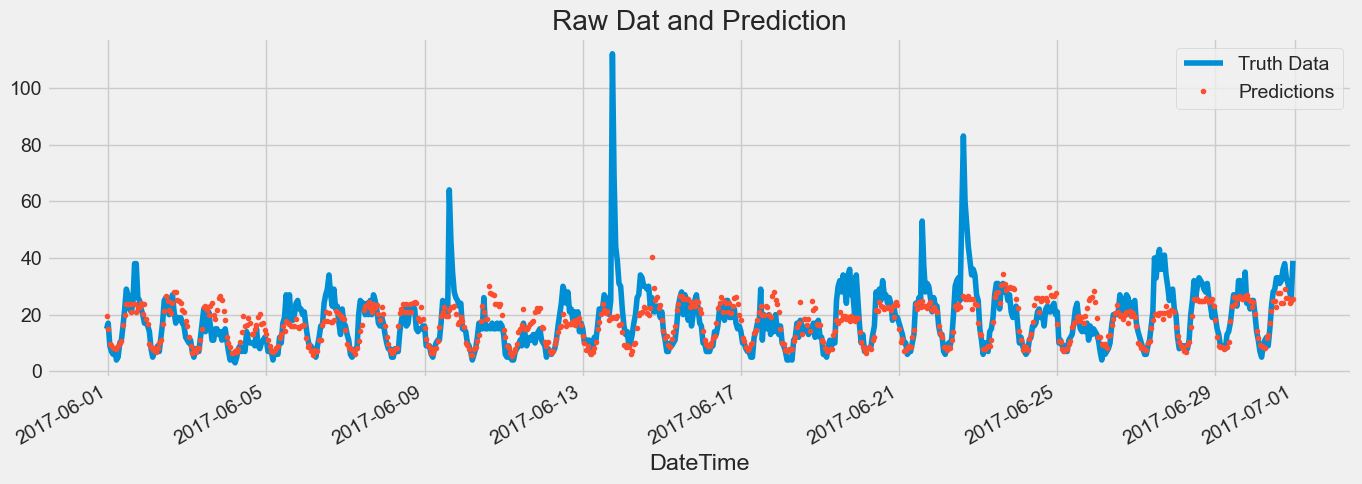

In [41]:
test['prediction'] = y_pred
y_test_ = pd.DataFrame(y_test)
y_test_ = y_test_.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = y_test_[['Vehicles']].plot(figsize=(15, 5))
y_test_['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [42]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')
print(f'R2 Score across folds {scores_r2}')
print(f'R2 Score across folds {np.mean(scores_r2):0.4f}')

Score across folds 7.4511
Fold scores:[10.082472485160636, 6.594703620698978, 8.536225302787845, 4.333399859774202, 7.708942556816416]
R2 Score across folds [0.3400233027675196, 0.49193239184696935, 0.5048174533138763, 0.5112748689067697, 0.42100500151785114]
R2 Score across folds 0.4538


In [43]:
def sub_plots_2(df_1, df_2, title ,m):
    fig, axes = plt.subplots(1, 2, figsize=(25,4), sharey=True, facecolor="#627D78")
    fig.suptitle(title)
    
    pl_1 = sns.lineplot(ax=axes[0], data=df_1, color=color_pal[m])
    axes[0].set(ylabel ="Prediction")
    
    pl_2 = sns.lineplot(ax=axes[1], data=df_2, color="#627D78")
    axes[1].set(ylabel ="Original")

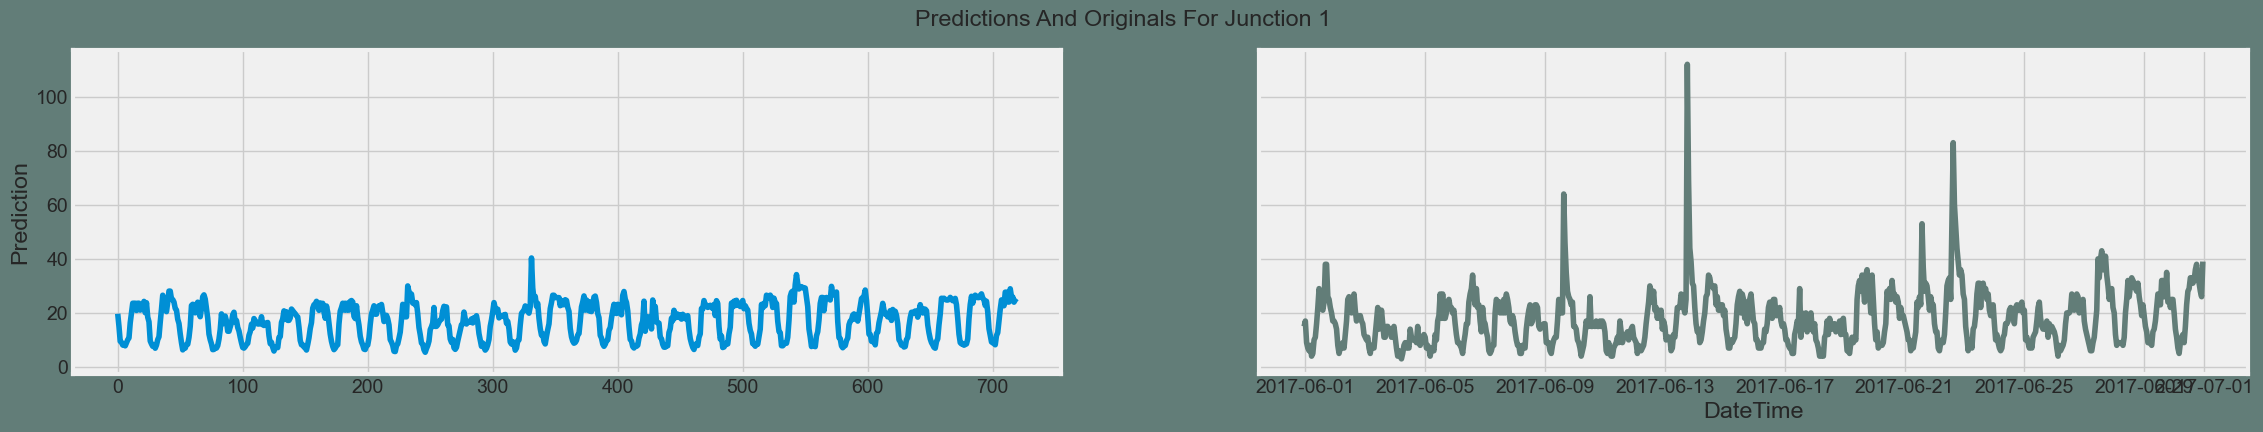

In [44]:
sub_plots_2(y_pred, y_test ,"Predictions And Originals For Junction 1", 0)

In [45]:
len(y_test), len(y_pred)

(720, 720)

In [46]:
type(y_test), type(y_pred)
y_test

DateTime
2017-05-31 23:00:00    15
2017-06-01 00:00:00    17
2017-06-01 01:00:00     9
2017-06-01 02:00:00     7
2017-06-01 03:00:00     6
                       ..
2017-06-30 19:00:00    33
2017-06-30 20:00:00    31
2017-06-30 21:00:00    28
2017-06-30 22:00:00    26
2017-06-30 23:00:00    39
Name: Vehicles, Length: 720, dtype: int64